# Final size comparisons

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from base_model import simulate as base_simulate
from model import simulate as two_way_simulate
from grab_data import *
from analysis import filter_flat_pop
import matplotlib.pyplot as plt

# Overall final sizes
Compare attack rates of 2-way mixing with simple mixing.

## Input data

In [62]:
DATASET = 'CENSUS_LAD11'
flow_matrix = get_matrix(DATASET, full=True)
population_sizes = get_population_sizes(DATASET)
total_pop = population_sizes.sum()
population_names = get_population_ordering(DATASET)
samples = 50
R0 = 4.2
incubation_period_days = 5
params = dict(beta=R0 / incubation_period_days, gamma=1 / incubation_period_days, psi=2 / 3, flow_matrix=flow_matrix,
              population_sizes=population_sizes,
              t_delta=1 / 12,
              t_max=100, seed=0, seed_amount=1)

## Calculate final size

In [63]:
def final_size_dist(simulator, model, params, k=50):
    commuter_samples = np.zeros(shape=(k, flow_matrix.shape[0]))
    total_samples = np.zeros(shape=(k, flow_matrix.shape[0]))
    for j in range(k):
        s, i, *_ = simulator(**params, model=model)
        while i.sum(axis=(0, 1, 2)) / (population_sizes.sum()) < 0.1:
            s, i, *_ = simulator(**params, model=model)
        commuter_s, commuter_i, home_s, home_i = filter_flat_pop(s, i)
        commuter_samples[j, :] = 1 - commuter_s[-1, :] / population_sizes
        total_samples[j, :] = 1 - (commuter_s[-1] + home_s[-1]) / population_sizes
    return commuter_samples.T, total_samples.T

## Simulate from models

In [47]:
base_random_commuter_f, base_random_total_f = final_size_dist(base_simulate, 'random', params, k=samples)
base_perfect_commuter_f, base_perfect_total_f = final_size_dist(base_simulate, 'perfect', params, k=samples)

In [48]:
two_way_perfect_commuter_f, two_way_perfect_total_f = final_size_dist(two_way_simulate, 'perfect', params, k=samples)

In [60]:
two_way_perfect_total_f.shape
two_way_perfect_commuter_f.shape

(346, 50)

## Commuter final size comparisons

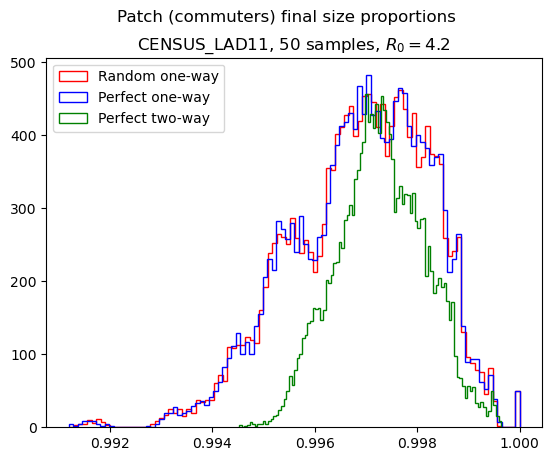

In [64]:
plt.hist(base_random_commuter_f.flatten(), label='Random one-way', color='r', bins=100, histtype='step')
plt.hist(base_perfect_commuter_f.flatten(), label='Perfect one-way', color='b', bins=100, histtype='step')
plt.hist(two_way_perfect_commuter_f.flatten(), label='Perfect two-way', color='g', bins=100, histtype='step')

plt.suptitle('Patch (commuters) final size proportions')
plt.title(f'{DATASET}, {samples} samples, $R_0 = {R0}$')
plt.legend()
plt.show()

## Patch total final size comparison

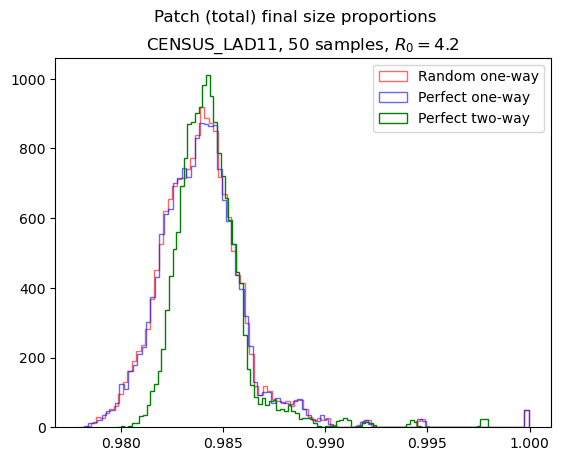

In [65]:
plt.hist(base_random_total_f.flatten(), label='Random one-way', color='r', alpha=0.6, bins=100, histtype='step')
plt.hist(base_perfect_total_f.flatten(), label='Perfect one-way', color='b', bins=100, alpha=0.6, histtype='step')
plt.hist(two_way_perfect_total_f.flatten(), label='Perfect two-way', color='g', bins=100, histtype='step')

plt.suptitle('Patch (total) final size proportions')
plt.title(f'{DATASET}, {samples} samples, $R_0 = {R0}$')
plt.legend()
plt.show()

## Overall final size comparison

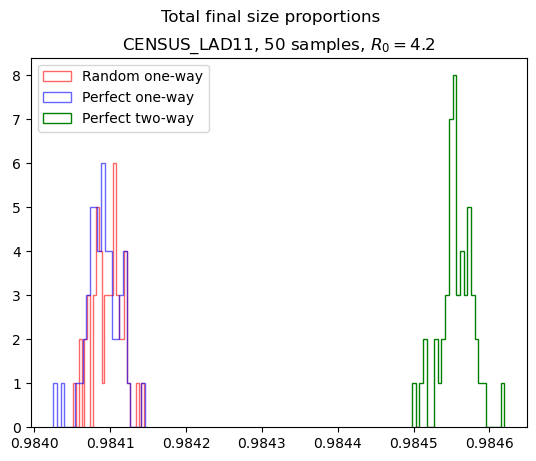

In [66]:
plt.hist((base_random_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Random one-way',
         color='r', alpha=0.6, histtype='step', bins=25)
plt.hist((base_perfect_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Perfect one-way',
         color='b', alpha=0.6, histtype='step', bins=25)
plt.hist((two_way_perfect_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Perfect two-way',
         color='g', histtype='step', bins=25)
plt.legend()
plt.suptitle('Total final size proportions')
plt.title(f'{DATASET}, {samples} samples, $R_0 = {R0}$')
plt.show()

# Effect of $R_0$ on final size difference

In [57]:
r0s = [1.2, 1.6, 2, 3]

In [86]:
base_params = dict(gamma=1 / incubation_period_days, psi=2 / 3, flow_matrix=flow_matrix,
                   population_sizes=population_sizes,
                   t_delta=1 / 12,
                   t_max=100, seed=0, seed_amount=1)
one_way_res = np.zeros(shape=(len(r0s), len(population_sizes), samples))

two_way_res = np.zeros(shape=(len(r0s), len(population_sizes), samples))
for index,r0 in enumerate(r0s):
    base_params['beta']  = r0 / incubation_period_days
    _, base_perfect_total_f = final_size_dist(base_simulate, 'perfect', base_params, k=samples)
    _, two_way_perfect_total_f = final_size_dist(two_way_simulate, 'perfect', base_params, k=samples)
    one_way_res[index] = base_perfect_total_f
    two_way_res[index] = two_way_perfect_total_f

KeyboardInterrupt: 

In [75]:
total_one_way = (one_way_res * population_sizes[np.newaxis,:,np.newaxis]).sum(axis=1)/total_pop
total_two_way = (two_way_res*population_sizes[np.newaxis,:,np.newaxis]).sum(axis=1)/total_pop

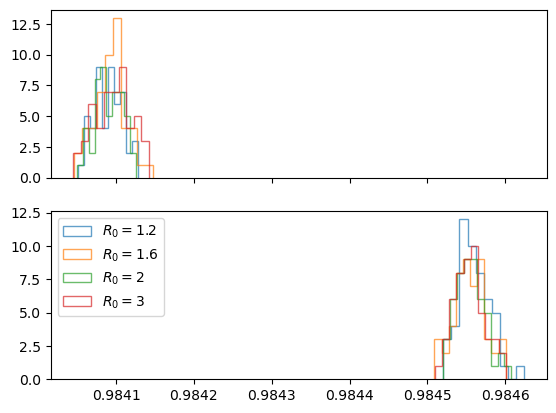

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
for index,r0 in enumerate(r0s):
    ax[0].hist(total_one_way[index], label=f'$R_0 = {r0}$', alpha=0.7, histtype='step', bins=10)
    ax[1].hist(total_two_way[index], label=f'$R_0 = {r0}$', alpha=0.7, histtype='step', bins=10)
plt.legend()
plt.show()